# Mice sleep
This jupiter notebook should show some of the implementation described in the project report. 

- The total **execution time** is on a macbook pro 2015 ca. **10min**  


## Python Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import experiments.lib.features as features
import experiments.lib.breeds as breeds
import experiments.lib.plots as plots
import experiments.lib.models as models

## Data import
We add directly the artifical features `time`, `day` and `hours` to our dataset. This represents better the fact, that the measurments have been taken each 4 seconds over a timespan of 4 days.

In [2]:
data_folder = 'data/csv/'
file = '10101.smo.csv'

df = features.load_features(data_folder + file)

# adding time features
df = features.add_times(df)

def to_hours(tick):
    return tick / 900.0

df['hours'] = df.index.map(to_hours)

## Data exploration

### Size of single mouse data set
Each 4 seconds over 4 days a datapoint is taken. This accumulates in a total of 86400 datapoints.

In [3]:
df.shape[0]

86400

### Given features
Where the `state` column can have the state `['n', 'r', 'w']` and the `rawState` column can have a values `['n', 'r', 'w', 1, 2, 3, 4, 5, 6]`.

In [4]:
df.head()

,rawState,state,EEGv,EMGv,temp,bin0,bin1,bin2,bin3,bin4,...,bin394,bin395,bin396,bin397,bin398,bin399,bin400,time,day,hours
0,w,w,3.342857e-09,1.083345e-09,0.0,3.912300e-06,1.514550e-06,1.211280e-06,0.000002,0.000002,...,6.094930e-10,8.133010e-10,1.189640e-09,7.768460e-10,9.402300e-10,4.209450e-09,1.345790e-08,0,0,0.000000
1,w,w,3.131613e-09,5.783424e-09,0.0,9.862400e-07,9.839130e-06,2.025640e-05,0.000003,0.000013,...,1.927580e-09,3.126100e-09,2.432780e-09,2.413940e-09,1.469330e-09,6.011740e-09,1.092040e-08,1,0,0.001111
2,w,w,3.202955e-09,1.809422e-09,0.0,9.996850e-06,4.128540e-06,9.773820e-07,0.000022,0.000019,...,6.916030e-10,1.181180e-10,2.069190e-09,2.783830e-09,1.742830e-09,3.697150e-09,7.224770e-09,2,0,0.002222
3,w,w,3.295155e-09,1.861343e-09,0.0,8.497950e-07,3.022740e-07,8.323700e-06,0.000009,0.000003,...,4.721880e-09,4.830450e-09,3.305080e-09,3.367690e-09,2.261620e-09,2.331490e-09,5.494020e-10,3,0,0.003333
4,w,w,3.245190e-09,1.245901e-08,0.0,6.184870e-06,2.382090e-05,1.600790e-05,0.000004,0.000001,...,5.141240e-10,6.648100e-10,5.028890e-10,3.504270e-10,1.121220e-10,5.087680e-09,1.123700e-08,4,0,0.004444


### State
The mouse is either in 'w' = wake, 'n'= REM sleep and 'n' = NREM sleep phase. Depicted below are the number of measurements in each state and the relation between `EEGv`, `EMGv` and the state for the first day. 

state
n    33955
r     3695
w    48750
dtype: int64


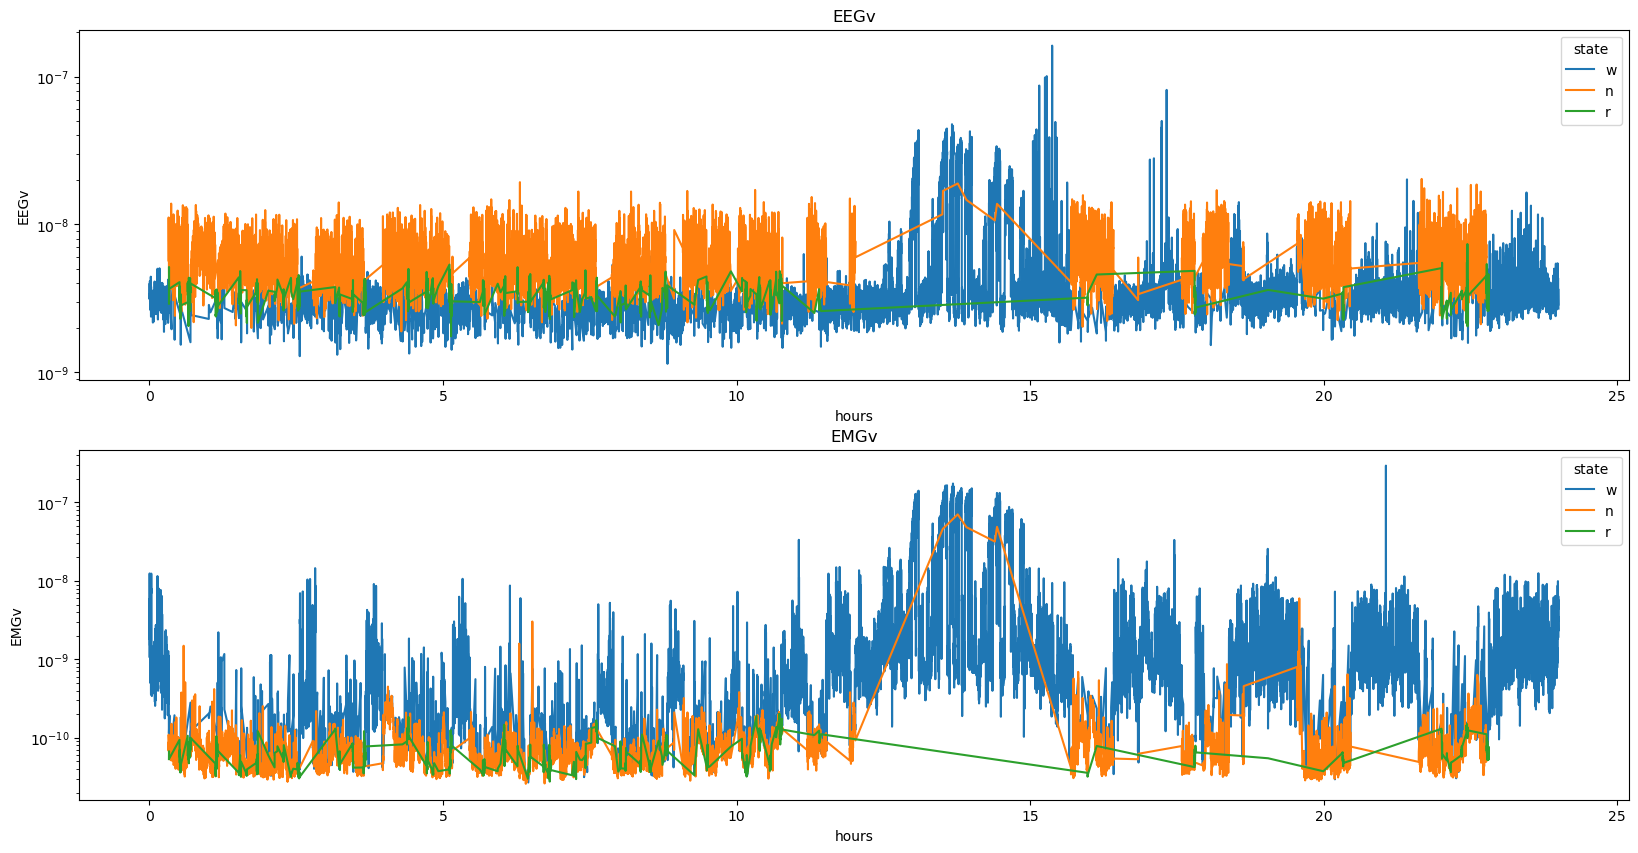

In [5]:
print(df.groupby('state').size())

plots.plot_df(data=df, day=0, log=True)

### Distribution of sleep phases depending on EEGv and EMGv over 4 days

Note that the mouse was gently disturbed during the third day.

<Figure size 3840x2880 with 0 Axes>

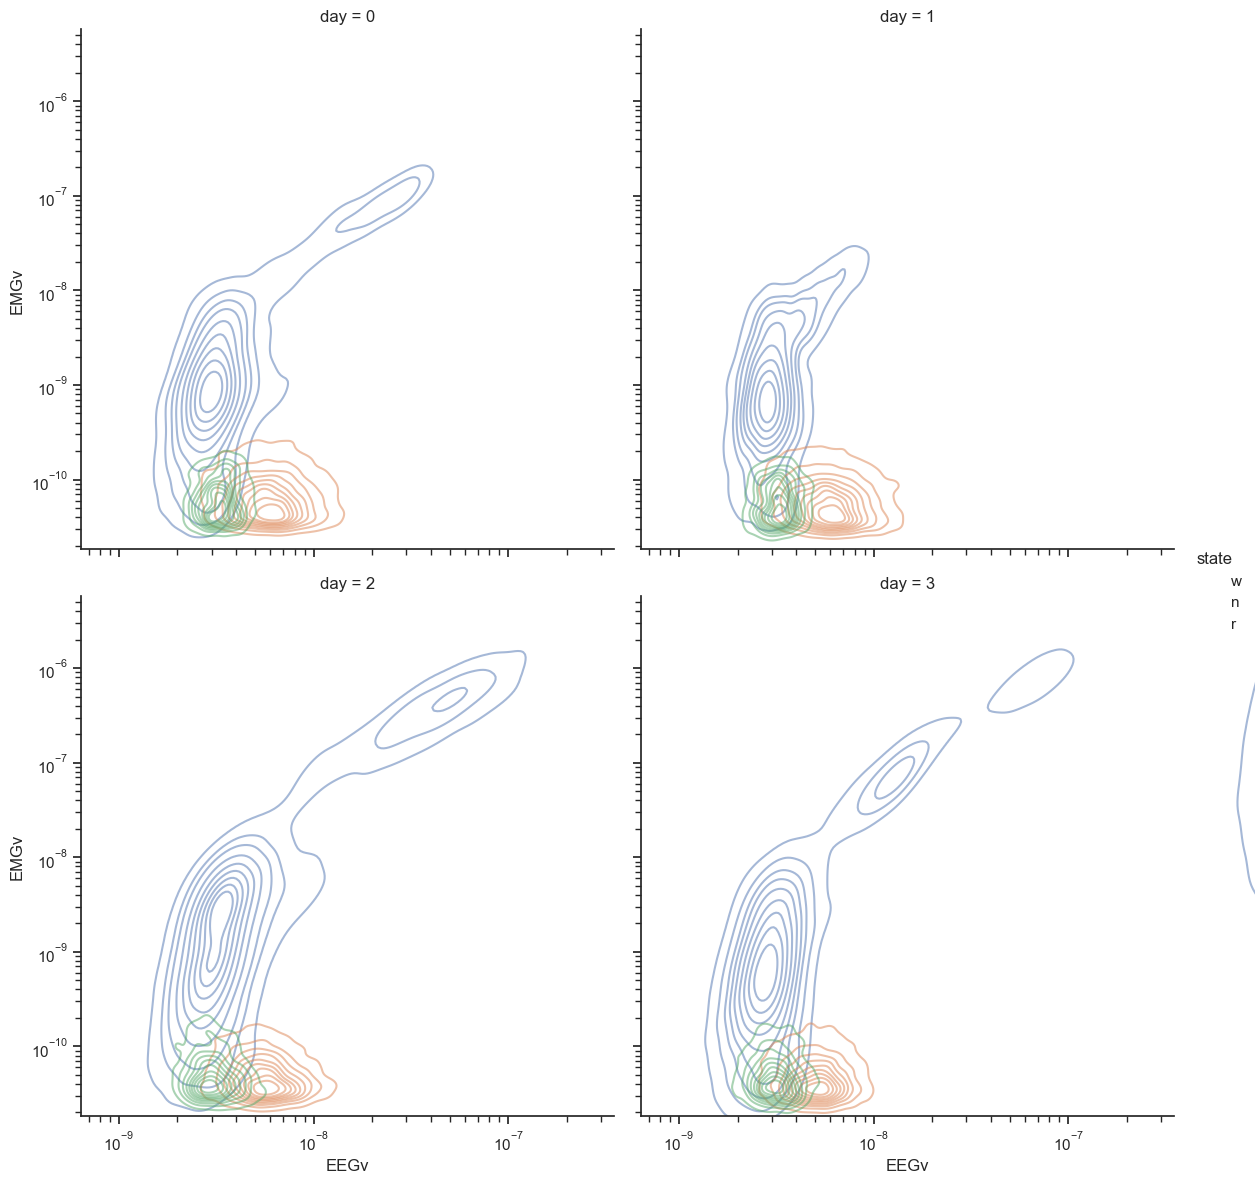

In [6]:
plots.density(df)
plt.show()

### Frequency domain

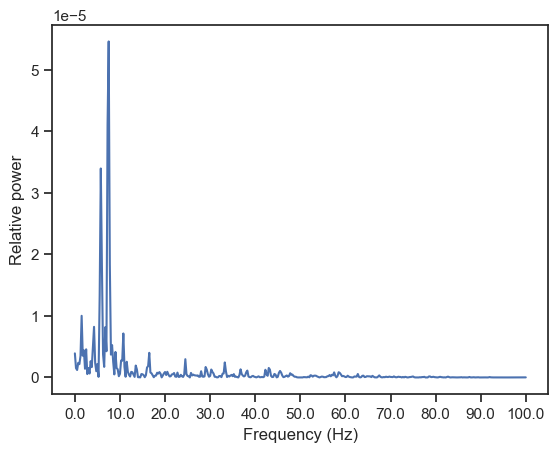

In [11]:
# DFT for one 4s epoch

bins = [f"bin{i}" for i in range(401)]
df.iloc[0][bins].plot()

# remap x axis from 0 to 100 Hz
plt.xticks(np.arange(0, 401, 40), np.arange(0, 100.1, 10))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power')
plt.show()


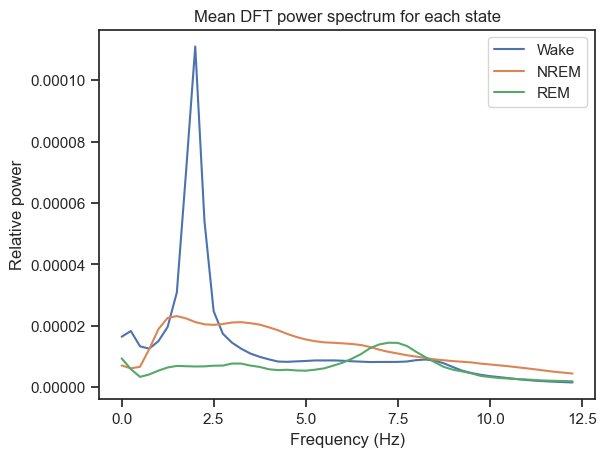

In [117]:
# mean DFT for each state

df.query('state == "w"')[bins[0:50]].mean().plot()
df.query('state == "n"')[bins[0:50]].mean().plot()
df.query('state == "r"')[bins[0:50]].mean().plot()

# remap x axis from 0 to 12.5 Hz
#
plt.xticks(np.arange(0, 51, 10), np.arange(0, 12.6, 2.5))

plt.title('Mean DFT power spectrum for each state')
plt.legend(['Wake', 'NREM', 'REM'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power')
plt.show()

## Feature engineering
The order of the sections corresponds to the order in the main pipeline (`features.clean_data`)

### A: Exploiting the EEG frequency spectrum


In [12]:
df_features = df.copy()

# 1) Spectral Flatness Measure
df_features = features.spectral_flatness(df_features)

# 2) Sepectral roll-off (0.5 = 50% of the total energy)): 
df_features = features.spectral_rolloff(df_features, 0.5)

# 3) Spectral Centroid
df_features = features.spectral_centroid(df_features)

# 4) Spectral entropy
df_features = features.spectral_entropy(df_features)

# Drop the raw bins
for i in range(401):
        df_features = df_features.drop([f"bin{i}"], axis=1)

### B: Aggregating measurements

In [28]:
df_features = features.add_feature_windows(df_features, [10], ['EEGv', 'EMGv'])

### C: Eliminating outliers

In [29]:
df_features = features.remove_outliers_quantile(df_features, ['EEGv', 'EMGv'], threshold=0.99)

### D: Adding non-linearity

In [30]:
# Add log features
df_features = features.log_features(df_features, ['EEGv', 'EMGv'])

# Add polynomial features
df_features = features.expand_features_poly(df_features, 3, ['EEGv', 'EMGv'])

### E: Rebalancing

In [32]:
df_features = features.rebalance_labels(df_features, seed=13)

### F: Normalization and standardization

In [33]:
# drop unwanted features
df_features = df_features.drop(['rawState', "temp"], axis=1)

# Split into train and test set and standardize
x_train, x_test, y_train, y_test, le = features.split_encode_scale_data(df_features, False, 0.3, 13, True)

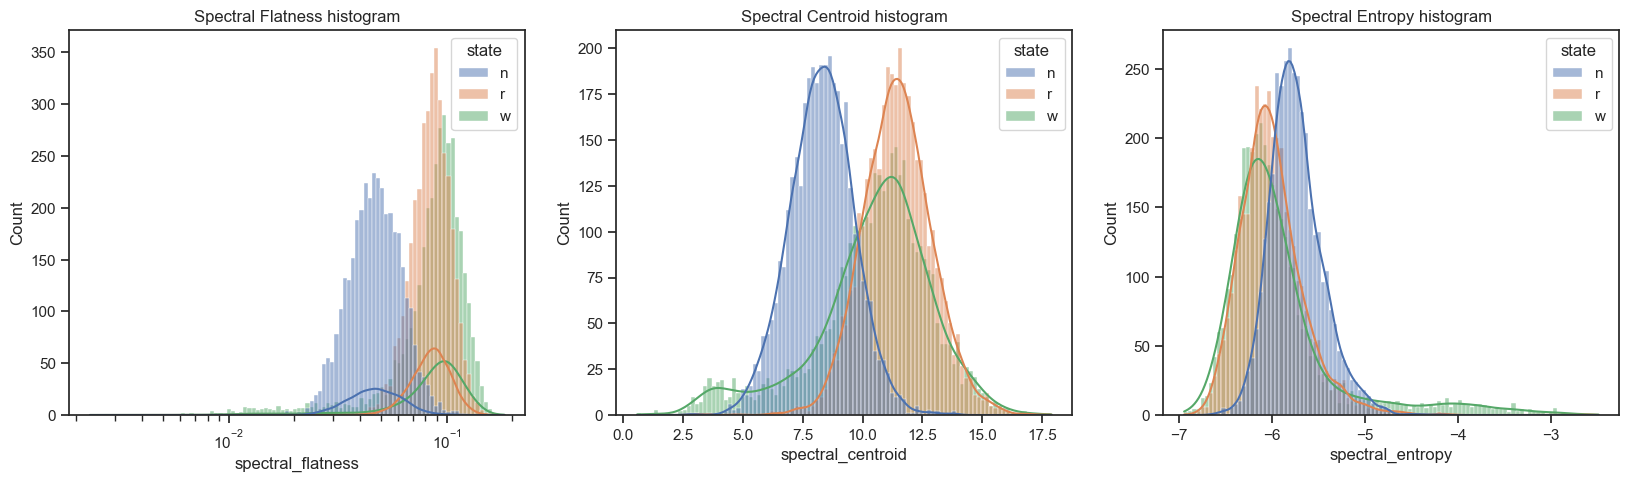

In [73]:
# plot the spectral features
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(df_features, x="spectral_flatness", hue="state", bins=100, kde=True, log_scale=True, ax=axs[0])
axs[0].set_title("Spectral Flatness histogram")

sns.histplot(df_features, x='spectral_centroid', hue='state', bins=100, kde=True, ax=axs[1])
axs[1].set_title("Spectral Centroid histogram")


sns.histplot(df_features, x='spectral_entropy', hue='state', bins=100, kde=True, ax=axs[2])
axs[2].set_title("Spectral Entropy histogram")

plt.show()

## Model fitting


### Neural Network

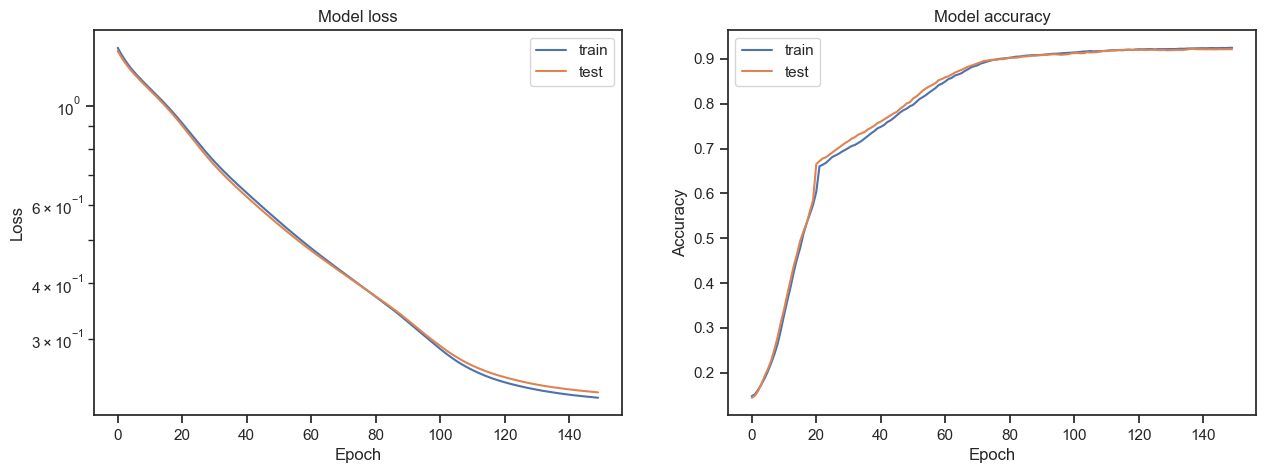

In [82]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=1e-4)
# train the model
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=150,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

# plot the training history
plots.plot_history(history.history)

103/103 [==============================] - 0s 730us/step
[[1023   56   19]
 [  65 1043   34]
 [  27   58  971]]
              precision    recall  f1-score   support

           n       0.92      0.93      0.92      1098
           r       0.90      0.91      0.91      1142
           w       0.95      0.92      0.93      1056

    accuracy                           0.92      3296
   macro avg       0.92      0.92      0.92      3296
weighted avg       0.92      0.92      0.92      3296



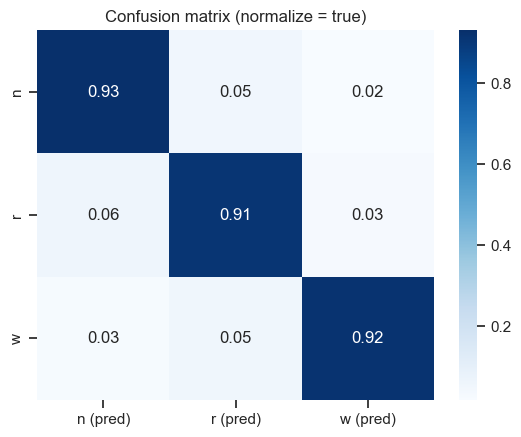

In [83]:
# Plot the confusion matrix
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

### Random forests

[[1036   52   10]
 [  81 1053    8]
 [  50   36  970]]
              precision    recall  f1-score   support

           n       0.89      0.94      0.91      1098
           r       0.92      0.92      0.92      1142
           w       0.98      0.92      0.95      1056

    accuracy                           0.93      3296
   macro avg       0.93      0.93      0.93      3296
weighted avg       0.93      0.93      0.93      3296



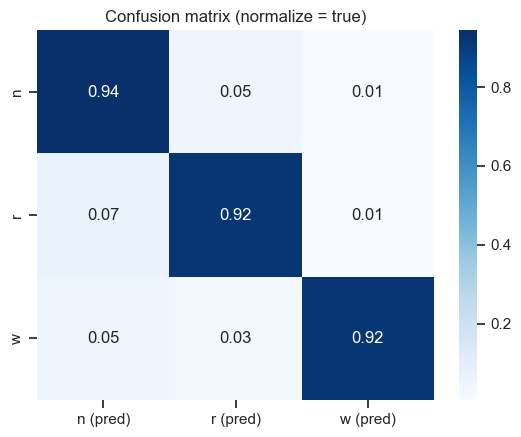

In [79]:
rfc = RandomForestClassifier(random_state=13)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')